In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from striprtf.striprtf import rtf_to_text
from IPython.display import display_html, display_markdown

import glob
import re
from zoneinfo import ZoneInfo

In [2]:
DATA_REPORTS_PATH = '../data/RTVSlo/Podatki - rtvslo.si/**/*.rtf'
DATA_PROMET_SI_PATH = '../data/RTVSlo/Podatki - PrometnoPorocilo_2022_2023_2024.xlsx'

## Loading the Data

In [ ]:
def _read_one_traffic_report(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        rtf_content = f.read()
        text = rtf_to_text(rtf_content)
    return text


def _read_traffic_reports(paths: list[str]):
    reports = []
    for i, path in enumerate(paths):
        print(f'Reading traffic report {i+1} of {len(paths)}', end='\r')
        report_cur = _read_one_traffic_report(path)
        reports.append(report_cur)
    print(f'Finished reading {len(reports)} traffic news reports.')
    return reports


def _parse_traffic_report(report: str):
    lines = [line.strip() for line in report.split('\n') if line.strip()]
    header = lines[0].replace('\t', '    ').replace('-', ' ').replace('..', '.')

    # Parse date, hardcoded fixes for some dataset inconsitencies -_-
    header = header.replace('10. 10. 22', '10. 10. 2022')
    date_pattern = re.compile(r'\d{1,2}[\. ] ?\d{1,2}[\. ] ?\d{4}')
    date_match = date_pattern.search(header)
    date_str = date_match.group() if date_match else None

    # Parse report type and main content
    report_type = header[:date_match.span()[0]].strip() if date_match else None
    content = '\n'.join(lines[1:]) # TODO This is not done particularly well ...

    # Parse time
    time_pattern = re.compile(r'\b\d{1,2}[.:]\d{2}\b')
    time_pos = date_match.span()[1] if date_match else 0
    time_match = time_pattern.search(header, pos=time_pos)
    time_str = time_match.group() if time_match else None

    # Parse programme
    i_time_end = time_match.span()[1] if time_match else None
    programme = header[i_time_end:].strip() if i_time_end else None

    return {
        'type': report_type,
        'date': date_str,
        'time': time_str,
        'programme': programme,
        'content': content
    }


def load_traffic_reports(paths: list[str]):
    # TODO Cache the parsed data frame somewhere to avoid reading individual files each time
    reports = _read_traffic_reports(paths)
    parsed_reports = [_parse_traffic_report(report) for report in reports]
    df_reports = pd.DataFrame(parsed_reports)
    df_reports['text'] = reports
    df_reports['path'] = paths

    # Remove empty documents
    mask_empty = (df_reports.text.str.strip().str.len() < 10)
    df_reports = df_reports[~mask_empty]
    print(f'Found and removed {mask_empty.sum()} ({mask_empty.mean()*100:.2f}%) empty documents.')

    # Store date and time as datetime objects
    df_reports['time'] = df_reports['time'].str.replace('.', ':')
    df_reports['date'] = df_reports['date'].str.replace('.', ' ').replace(r'\s+', '. ', regex=True)
    df_reports['datetime'] = pd.to_datetime(df_reports['date'] + ' ' + df_reports['time'], dayfirst=True, errors='coerce')
    print(f'Parsed datetime successfully for {df_reports.datetime.notna().sum()} ({df_reports.datetime.notna().mean()*100:.2f}%) documents. Removing the rest.')
    df_reports = df_reports[df_reports.datetime.notna()]
    df_reports = df_reports.sort_values('datetime')

    # Make types of reports consistent
    types_map = {
        'Prometne informacije': ['Prometne informacije', 'Prometna informacija', 'Prometne informacije.', 'Prometna informacija.', 'Prometne informacije:', 'Prometne informacije      11.', 'Prometne informacije        10.', 'Podatki o prometu.', 'Prometne informacijje', 'Podatki o prometu', 'Prometne informacije 1. program', 'rometne informacije', 'Pometne informacije', 'DIO ZAČETEK Prometna informacija', 'lPrometne informacije', 'informacije', '.Prometna informacija', 'metne informacije', 'Podatki o prometu:', 'PRAVA Prometne informacije'],
        'Nove prometne informacije': ['NOVE Prometne informacije', 'NOVA Prometne informacije', 'NOVE prometne informacije', 'NOVEPrometne informacije', 'NOVA Prometna informacija', 'NOVE Prometna informacija', 'NOVAPrometne informacije', 'NOVE NOVE Prometne informacije', 'NOVO Prometne informacije', 'Nove Prometne informacije', 'NOVE Prometne informacije:', 'NOVA  Prometne informacije', 'Nove prometne informacije.', 'NAJNOVEJŠE prometne informacije', 'NOVA  do   Prometne informacije', 'NOVE  informacije', 'NOVA +Prometne informacije', 'NOVE2 Prometne informacije', 'NOva Prometne informacije', 'ometne informacije', 'NOVAPrometna informacija', 'NOVE Prometne informacije.', 'NOVI Podatki o prometu', 'NOVA      Prometne informacije', 'Nova Prometne informacije'],
        'Nujne prometne informacije': ['Nujna prometna informacija', 'Nujna prometna informacija.', 'NUJNA Prometna informacija', 'NUJNO! Prometne informacije', 'Nujne prometne informacije', 'ujna prometna informacija.', 'NOVA Nujna prometna informacija'],
        None: ['PROMET RD,', '9:15', '7.30', '8.15']
    }

    for new_type, old_types in types_map.items():
        mask = df_reports['type'].isin(old_types)
        df_reports.loc[mask, 'type'] = new_type

    return df_reports

In [ ]:
def load_promet_si_data(path: str):
    # In the excel file, data is split by years into sheets, to read them all, use `sheet_name=None`
    sheet_to_df = pd.read_excel(path, sheet_name=None)
    df = pd.concat(sheet_to_df.values(), ignore_index=True)

    # Convert timestamp to local timezone (as used in the traffic reports). This will also handle daylight saving time transformations.
    zone = ZoneInfo('Europe/Ljubljana')
    df['Datum'] = df['Datum'].dt.tz_localize('UTC').dt.tz_convert(zone).dt.tz_localize(None)
    return df

In [6]:
report_paths = glob.glob(DATA_REPORTS_PATH, recursive=True)
df_reports = load_traffic_reports(report_paths)
df_promet = load_promet_si_data(DATA_PROMET_SI_PATH)

## Displaying a traffic report and relevant `Promet.si` entries

In [7]:
def display_traffic_report(report: pd.Series, n_promet_si_entries = 3):
    # Determine the promet.si entries related to report
    timestamp_ref = report['datetime']
    timestamp_diff = (df_promet['Datum'] - timestamp_ref).abs()
    timestamp_diff = timestamp_diff[df_promet['Datum'] <= timestamp_ref] # Only consider promet.si dates before the reference
    idx_closest = timestamp_diff.sort_values().index[:n_promet_si_entries]

    # Display the report
    dt_format = "%d. %m. %Y, %H:%M"
    display_markdown(f'# {report["type"]} (**{report["datetime"].strftime(dt_format)}**)', raw=True)
    print(report['content'])
    display_markdown(f'The {n_promet_si_entries} most relevant promet.si entries are displayed below.', raw=True)

    # Display the promet.si entries
    for i, (_, row) in enumerate(df_promet.loc[idx_closest].iterrows()):
        display_html('<hr>', raw=True)
        display_markdown(f'### [{i+1}] **{row.Datum.strftime("%d. %m. %Y, %H:%M")}**', raw=True)
        if pd.notna(row.A1): display_html(row.A1, raw=True)
        if pd.notna(row.B1): display_html(row.B1, raw=True)

In [9]:
row_report = df_reports.loc[5009]
display_traffic_report(row_report)

# Prometne informacije (**17. 06. 2022, 20:10**)

Izredna prometna informacija.
Vozniki na primorski avtocesti, ki se vozite od Vrhnike proti Ljubljani, bodite pozorni na voznika, ki vozi v nasprotni smeri. Držite se skrajno desno.
 


The 3 most relevant promet.si entries are displayed below.

### [1] **17. 06. 2022, 20:05**

Pozor! Previdno vozniki na primorski avtocesti, ki se vozite od Vrhnike proti Ljubljani, voznik vozi v napačno smer.

Zastoji Na gorenjski avtocesti pred predorom Karavanke proti Avstriji, 6 kilometrov. Proti Kranjski Gori priporočamo izvoz Jesenice vzhod, Lipce. Na primorski avtocesti med Logatcem in Vrhniko proti Ljubljani, zamuda 5 - 10 minut. Ovire Predor Karavanke je zaprt proti Avstriji zaradi izrednega prevoza. Mejni prehodi Čakalna doba: Dragonja in Gruškovje. Prireditve Do nedelje, 19. 6., bo potekala kolesarska dirka po Sloveniji . V soboto med 9:40 in 15:30 bodo občasne popolne zapore na relaciji Laško - Rimske Toplice - Hrastnik - Zagorje ob Savi - Izlake - Trojane - Blagovica - Lukovica - Dob - Vir - Domžale - Rodica - Mengeš - Moste - Komenda - Kamnik - Stahovica - Črnivec - Gornji Grad - Radmirje - Ljubno ob Savinji - Raduha - Luče - Podvolovljek - Kranjski Rak - Velika planina. Delo na cesti Cesta Tržič - Kranj bo pri Križah zaprta do sobote, 18. 6. 2022. Do 24. junija bo na primorski avtocesti zaprt izvoz Vrhnika iz smeri Kopra.

### [2] **17. 06. 2022, 19:58**

Zastoji Na gorenjski avtocesti pred predorom Karavanke proti Avstriji, 6 kilometrov. Proti Kranjski Gori priporočamo izvoz Jesenice vzhod, Lipce. Na primorski avtocesti med Logatcem in Vrhniko proti Ljubljani, zamuda 5 - 10 minut. Ovire Predor Karavanke je zaprt proti Avstriji zaradi izrednega prevoza. Mejni prehodi Čakalna doba: Dragonja in Gruškovje. Prireditve Do nedelje, 19. 6., bo potekala kolesarska dirka po Sloveniji . V soboto med 9:40 in 15:30 bodo občasne popolne zapore na relaciji Laško - Rimske Toplice - Hrastnik - Zagorje ob Savi - Izlake - Trojane - Blagovica - Lukovica - Dob - Vir - Domžale - Rodica - Mengeš - Moste - Komenda - Kamnik - Stahovica - Črnivec - Gornji Grad - Radmirje - Ljubno ob Savinji - Raduha - Luče - Podvolovljek - Kranjski Rak - Velika planina. Delo na cesti Cesta Tržič - Kranj bo pri Križah zaprta do sobote, 18. 6. 2022. Do 24. junija bo na primorski avtocesti zaprt izvoz Vrhnika iz smeri Kopra.

### [3] **17. 06. 2022, 19:57**

Zastoji Na gorenjski avtocesti pred predorom Karavanke proti Avstriji, 6 kilometrov. Proti Kranjski Gori priporočamo izvoz Jesenice vzhod, Lipce. Na primorski avtocesti med Logatcem in Vrhniko proti Ljubljani, zamuda 5 - 10 minut. Ovire Predor Karavanke je zaprt proti Avstriji zaradi izrednega prevoza. Mejni prehodi Čakalna doba: Dragonja in Gruškovje. Prireditve Do nedelje, 19. 6., bo potekala kolesarska dirka po Sloveniji . V soboto med 9:40 in 15:30 bodo občasne popolne zapore na relaciji Laško - Rimske Toplice - Hrastnik - Zagorje ob Savi - Izlake - Trojane - Blagovica - Lukovica - Dob - Vir - Domžale - Rodica - Mengeš - Moste - Komenda - Kamnik - Stahovica - Črnivec - Gornji Grad - Radmirje - Ljubno ob Savinji - Raduha - Luče - Podvolovljek - Kranjski Rak - Velika planina. Delo na cesti Cesta Tržič - Kranj bo pri Križah zaprta do sobote, 18. 6. 2022. Do 24. junija bo na primorski avtocesti zaprt izvoz Vrhnika iz smeri Kopra.

## Basic Exploratory Data Analysis

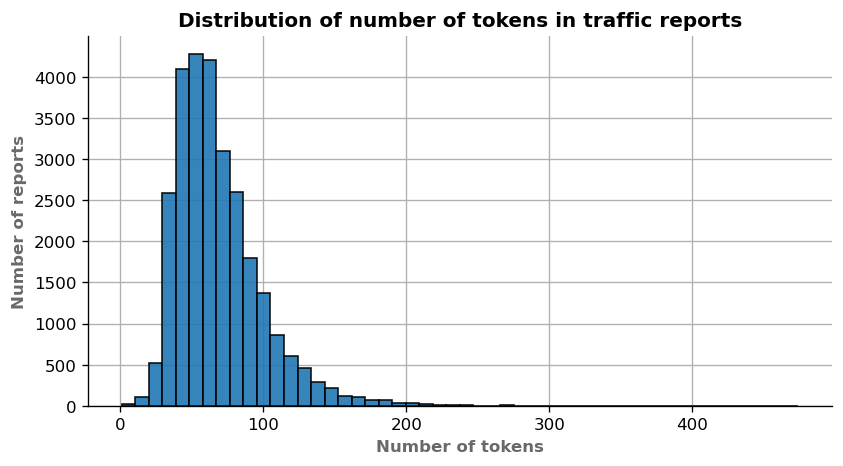

In [10]:
n_tokens = df_reports.content.str.split().str.len()
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
ax.hist(n_tokens, bins=50, edgecolor='black', zorder=10, alpha=0.9)
ax.spines[['right', 'top']].set_visible(False)
ax.set_title('Distribution of number of tokens in traffic reports', fontweight='bold')
ax.set_xlabel('Number of tokens', fontweight='bold', color='dimgray')
ax.set_ylabel('Number of reports', fontweight='bold', color='dimgray')
ax.grid()

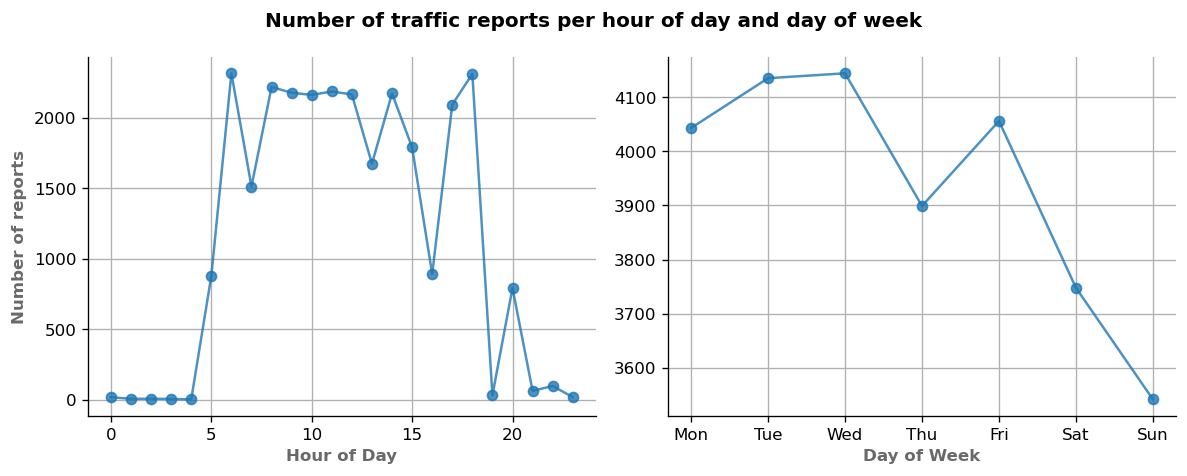

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

counts_per_hour = df_reports.groupby(df_reports.datetime.dt.hour).count()['type']
count_per_weekday = df_reports.groupby(df_reports.datetime.dt.weekday).count()['type']

axs[0].plot(counts_per_hour, '-o', alpha=0.8)
axs[1].plot(count_per_weekday, '-o', alpha=0.8)
axs[0].set_ylabel('Number of reports', fontweight='bold', color='dimgray')
axs[0].set_xlabel('Hour of Day', fontweight='bold', color='dimgray')
axs[1].set_xlabel('Day of Week', fontweight='bold', color='dimgray')
axs[1].set_xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
for ax in axs:
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid()
fig.suptitle('Number of traffic reports per hour of day and day of week', fontweight='bold')
fig.tight_layout()